In [1]:
#setup
options(repr.plot.width=16, repr.plot.height=16)
suppressPackageStartupMessages({
    library(admixtools)                                                  
    library(ape)                                                         
    library(tidyverse)  
    library(gplots)
    source("/home/peter/fstats_tutorial/scripts//analysis.R")
    source("/home/peter/fstats_tutorial/scripts//treemix_plotting2.R")
})

## From yesterday: estimating admixture proportions
The final task in the F-statistics framework will be to calculate admixture proportions using the $F_4$-ratio. 

For this purpose, we will use a data set that aims at estimating the proportion of Neandertal ancestry in modern humans, based on the analysis by [Petr et al. 2019](https://www.pnas.org/content/116/5/1639), who used the assumption that all Neanderthal ancestry is closer to a Neandertal from Vindija Cave (in Croatia) than a Neandertal genome from Denisova cave (Altai, Russia). 

We assume that the populations are related like this:
 <img src="https://raw.githubusercontent.com/BenjaminPeter/cph_course/copenhagen2021/F4.large.jpg" alt="F4-ratio" style="width: 400px;"/>
 
 and estimate the admixture proportion $\alpha$ as
 $$\alpha = \frac{f_4(A, O; X, C)}{f_4(A, O; B, C)}$$
 


To follow the analysis of [Petr et al. 2019](https://www.pnas.org/content/116/5/1639), we use the following population assignments 

- `A = 'Altai_Neanderthal.DG'`
- `B = 'Vindija_Neanderthal.DG'`
- `C = 'Mbuti'`
- `X = c("French", "Han", "Papuan")`
- `O = 'Primate_Chimp'`

   

**Task 0**: Use the `qpf4ratio`-function in `admixtools` to use the ancient data (that we used for the $D$-stats exercise to estimate the Neandertal ancestry in French, Han and Papuans.

- have a look at `?qpf4ratio` to figure out the arguments this function expects
- which population is in which position of the arguments? Construct a vector `v` or data frame that matches this order
- run the f4-ratio-estimation using `qpf4ratio(ancient, v)
- do the archaic ancestries differ between the three populations?

In [2]:
ancient = read_f2('/home/peter/fstats_tutorial/fdata/ancient') #load ancient data
pops = dimnames(ancient)[1][[1]] #obtain the names of the samples
pops

[1] "Altai_Neanderthal.DG"   "Denisova.DG"            "French"                
[4] "Han"                    "Mbuti"                  "Papuan"                
[7] "Primate_Chimp"          "Vindija_Neanderthal.DG" "Yoruba"

## 1. Estimating trees
Many methods to visualize population structure between many populations can be written as functions of a _distance matrix_, like a matrix of $F_2$ or $F_{ST}$-values. These methods include principal component analysis, trees and admixture graphs, the latter two we will focus on today. In distance matrices, large values mean that samples are less similar to each other, in contrast to similarity matrices where large values imply samples are _more_ alike.

In [3]:
#here we read all possible f2 values
f2s = read_f2('/home/peter/fstats_tutorial/fdata/worldfoci2')

#we arrange them into a matrix
f2_mat = f2_matrix(f2s)

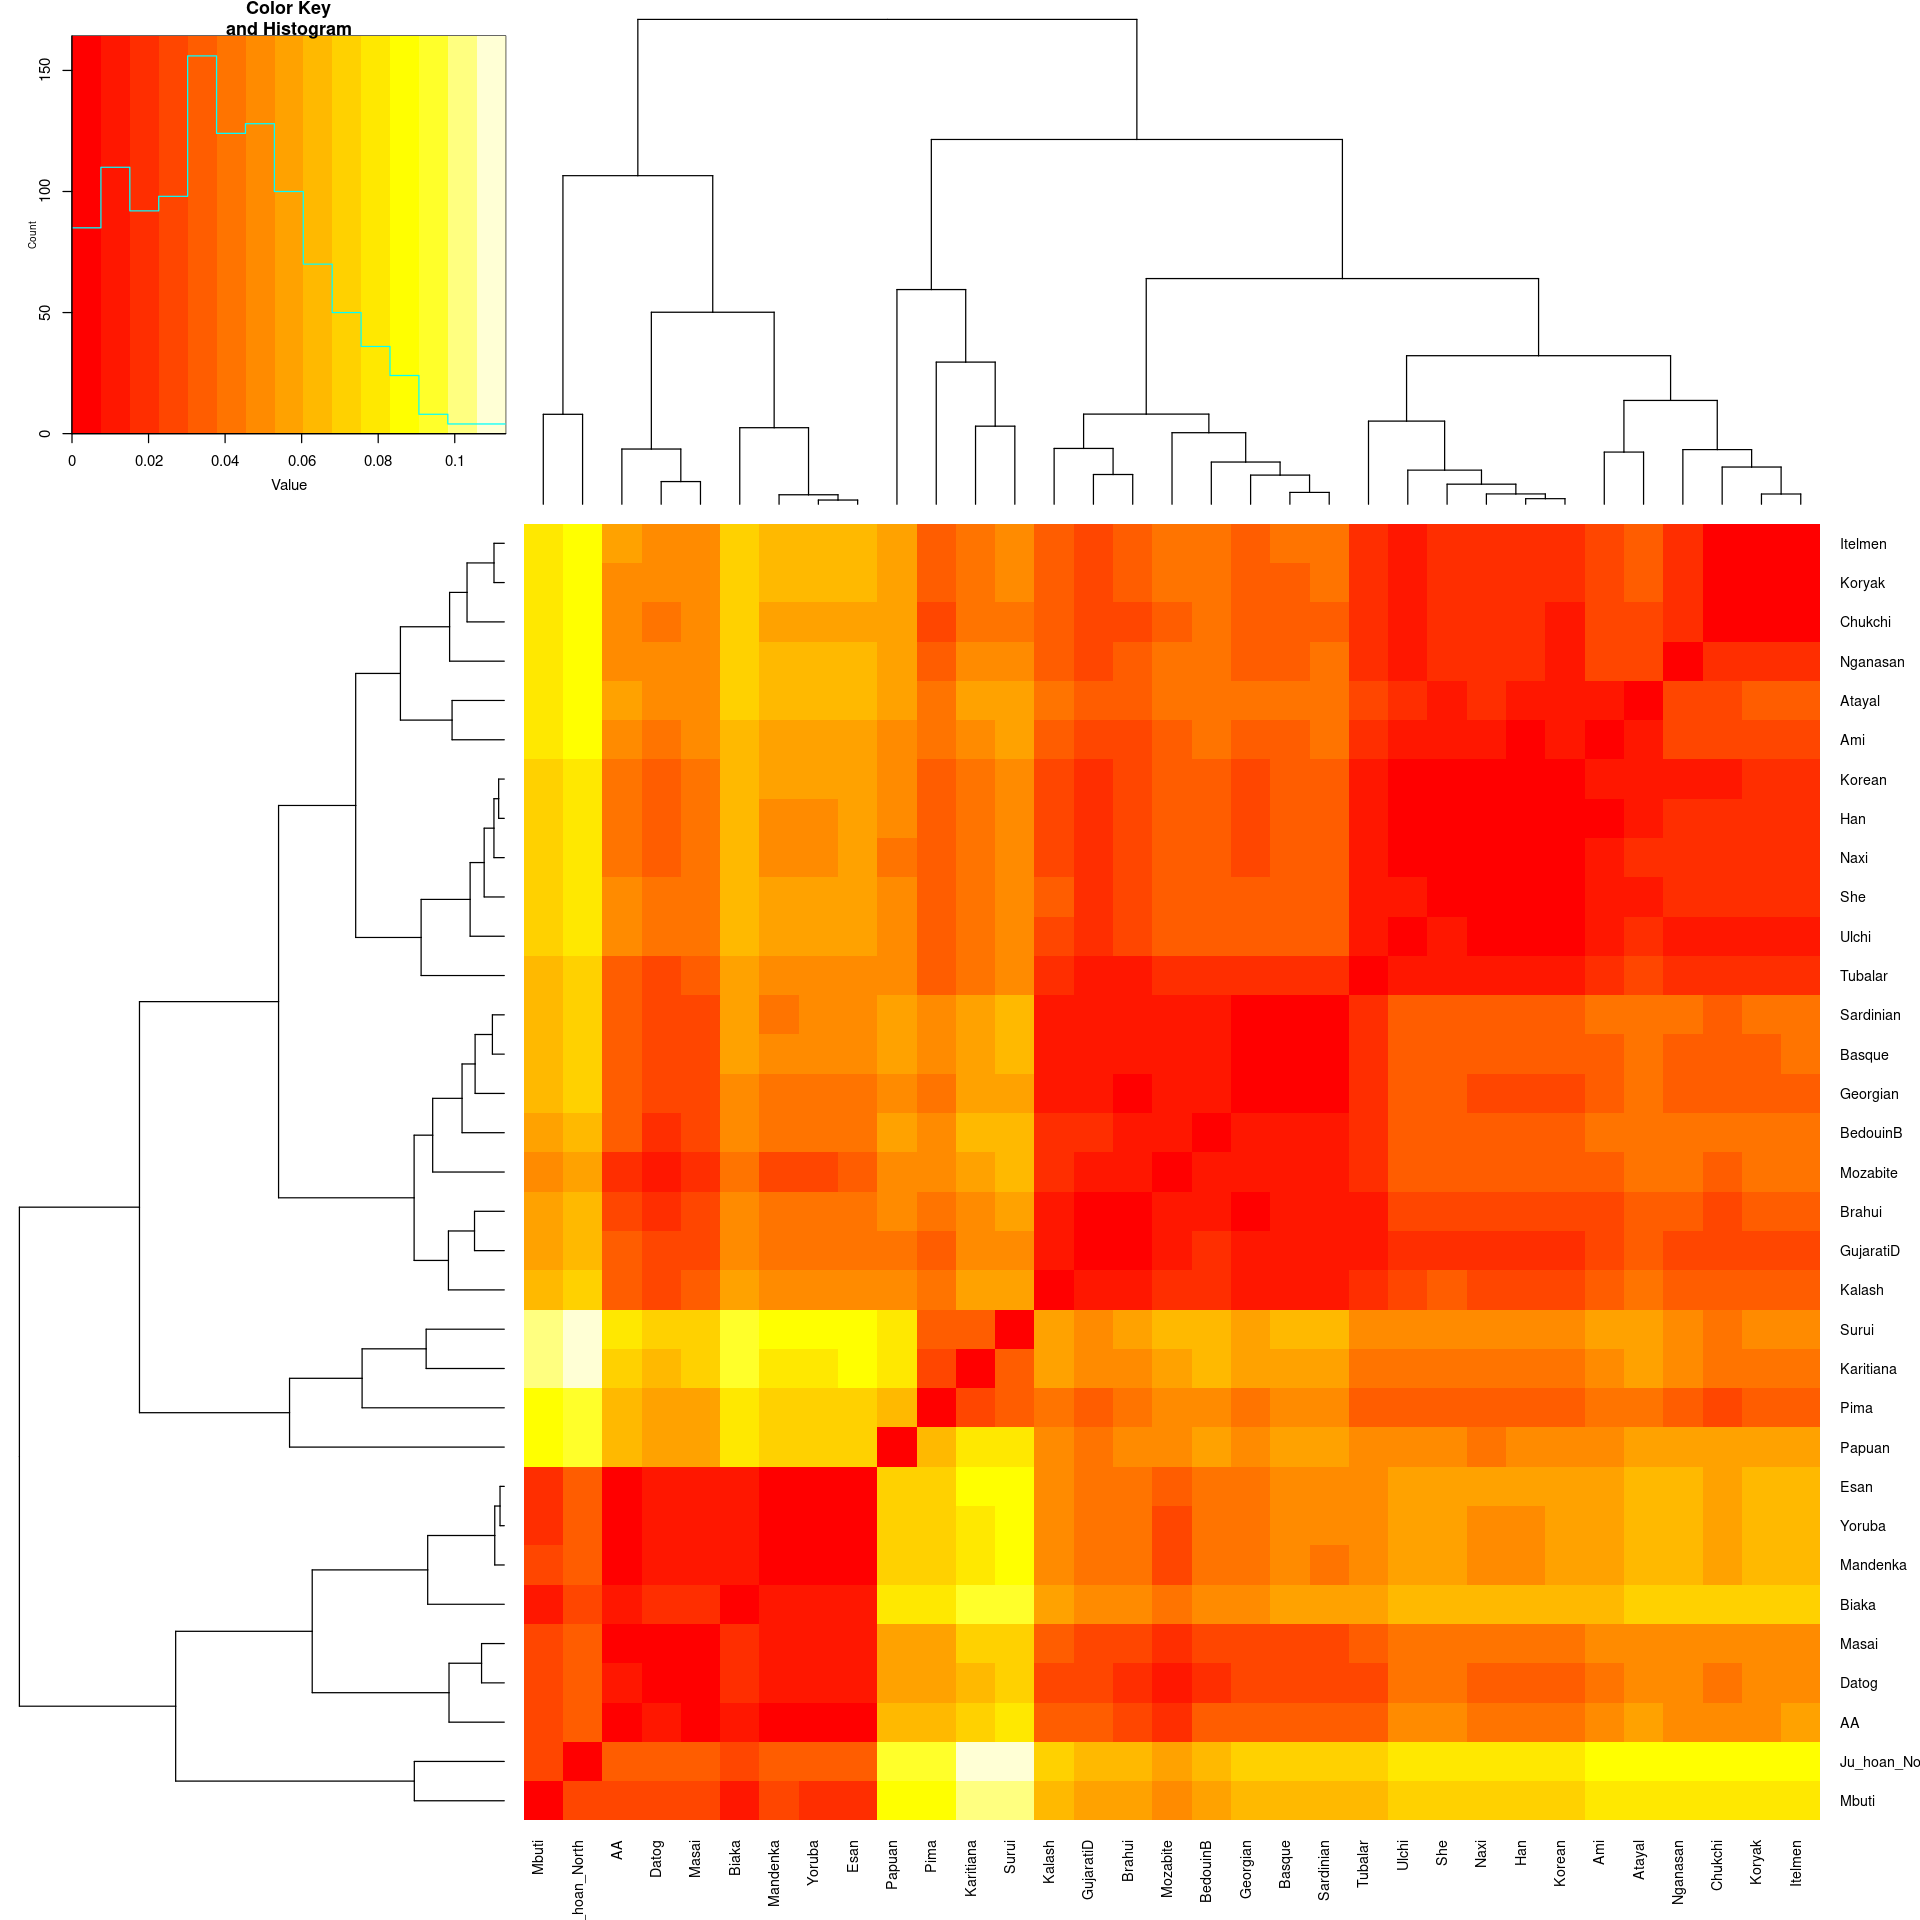

In [4]:
heatmap.2(f2_mat, symm=T, scale="none", trace='n') #this is the same function we used yesterday for FST

**Task 1:** Use the distance matrix in the `f2_mat`-matrix to generate a tree using the neighbor joining algorithm.
Use the following functions from the `ape` package:
 
 - `nj()` to calculate the tree
 - `root()` to set an appropriate root (like Mbuti)
 - `plot.phylo()` to visualize your data

In case you are not sure how these functions work, the help (typing e.g. `?nj` may help)

**Questions:**
   - Can you tell which populations might be admixed?
   - how does that relate to $f_3$-statistics?

## 2. Fitting admixture graphs using qpgraph
Our next task will be to use `qpgraph` to fit a graph. In contrast to `nj`, `qpgraph` does not estimate a graph, so one has to be specified. It will then fit all admixture proportions and branch lengths. One can think of this as obtaining "plausible" graphs that fit the data, without any statements whether they are the best or unique graph for that purpose. Thus, we have to specify a graph. The easiest way is to give it a list using 2 columns, where each row is anedge in the graph.

In [5]:
starting_graph = rbind(                   
              c("ROOT", "Mbuti"),       
              c("ROOT", "AFR"),              
              c("AFR", "AFR1"),           
              c("AFR1", "AA"),     
              c("AFR", "OOA"),            
              c("OOA", "EUR"),            
              c("OOA", "EAS"),            
              c("EUR", "Sardinian"),         
              c("EUR","AA"),       
              c("EAS", "Han")             
              )                             

For this purpose, we have to define a bunch of internal nodes (a useful convention is to use ALL-CAPS for internal nodes). I.e. in our starting graph, we start at the root, where we us the _Mbuti_ as an outgroup. Within Africa, we have two populations; the African component of the African-American population (_AA_), and the out-of-Africa population (OOA). Outside Africa, we split into Europe (EUR) and East Asians (EAS), represented by the _Sardinian_ and _Han_, respectively. Our hypothesis is that the African-Americans have some European ancestry, therefore we add a second edge from `EUR` to `AA` to reflect that.

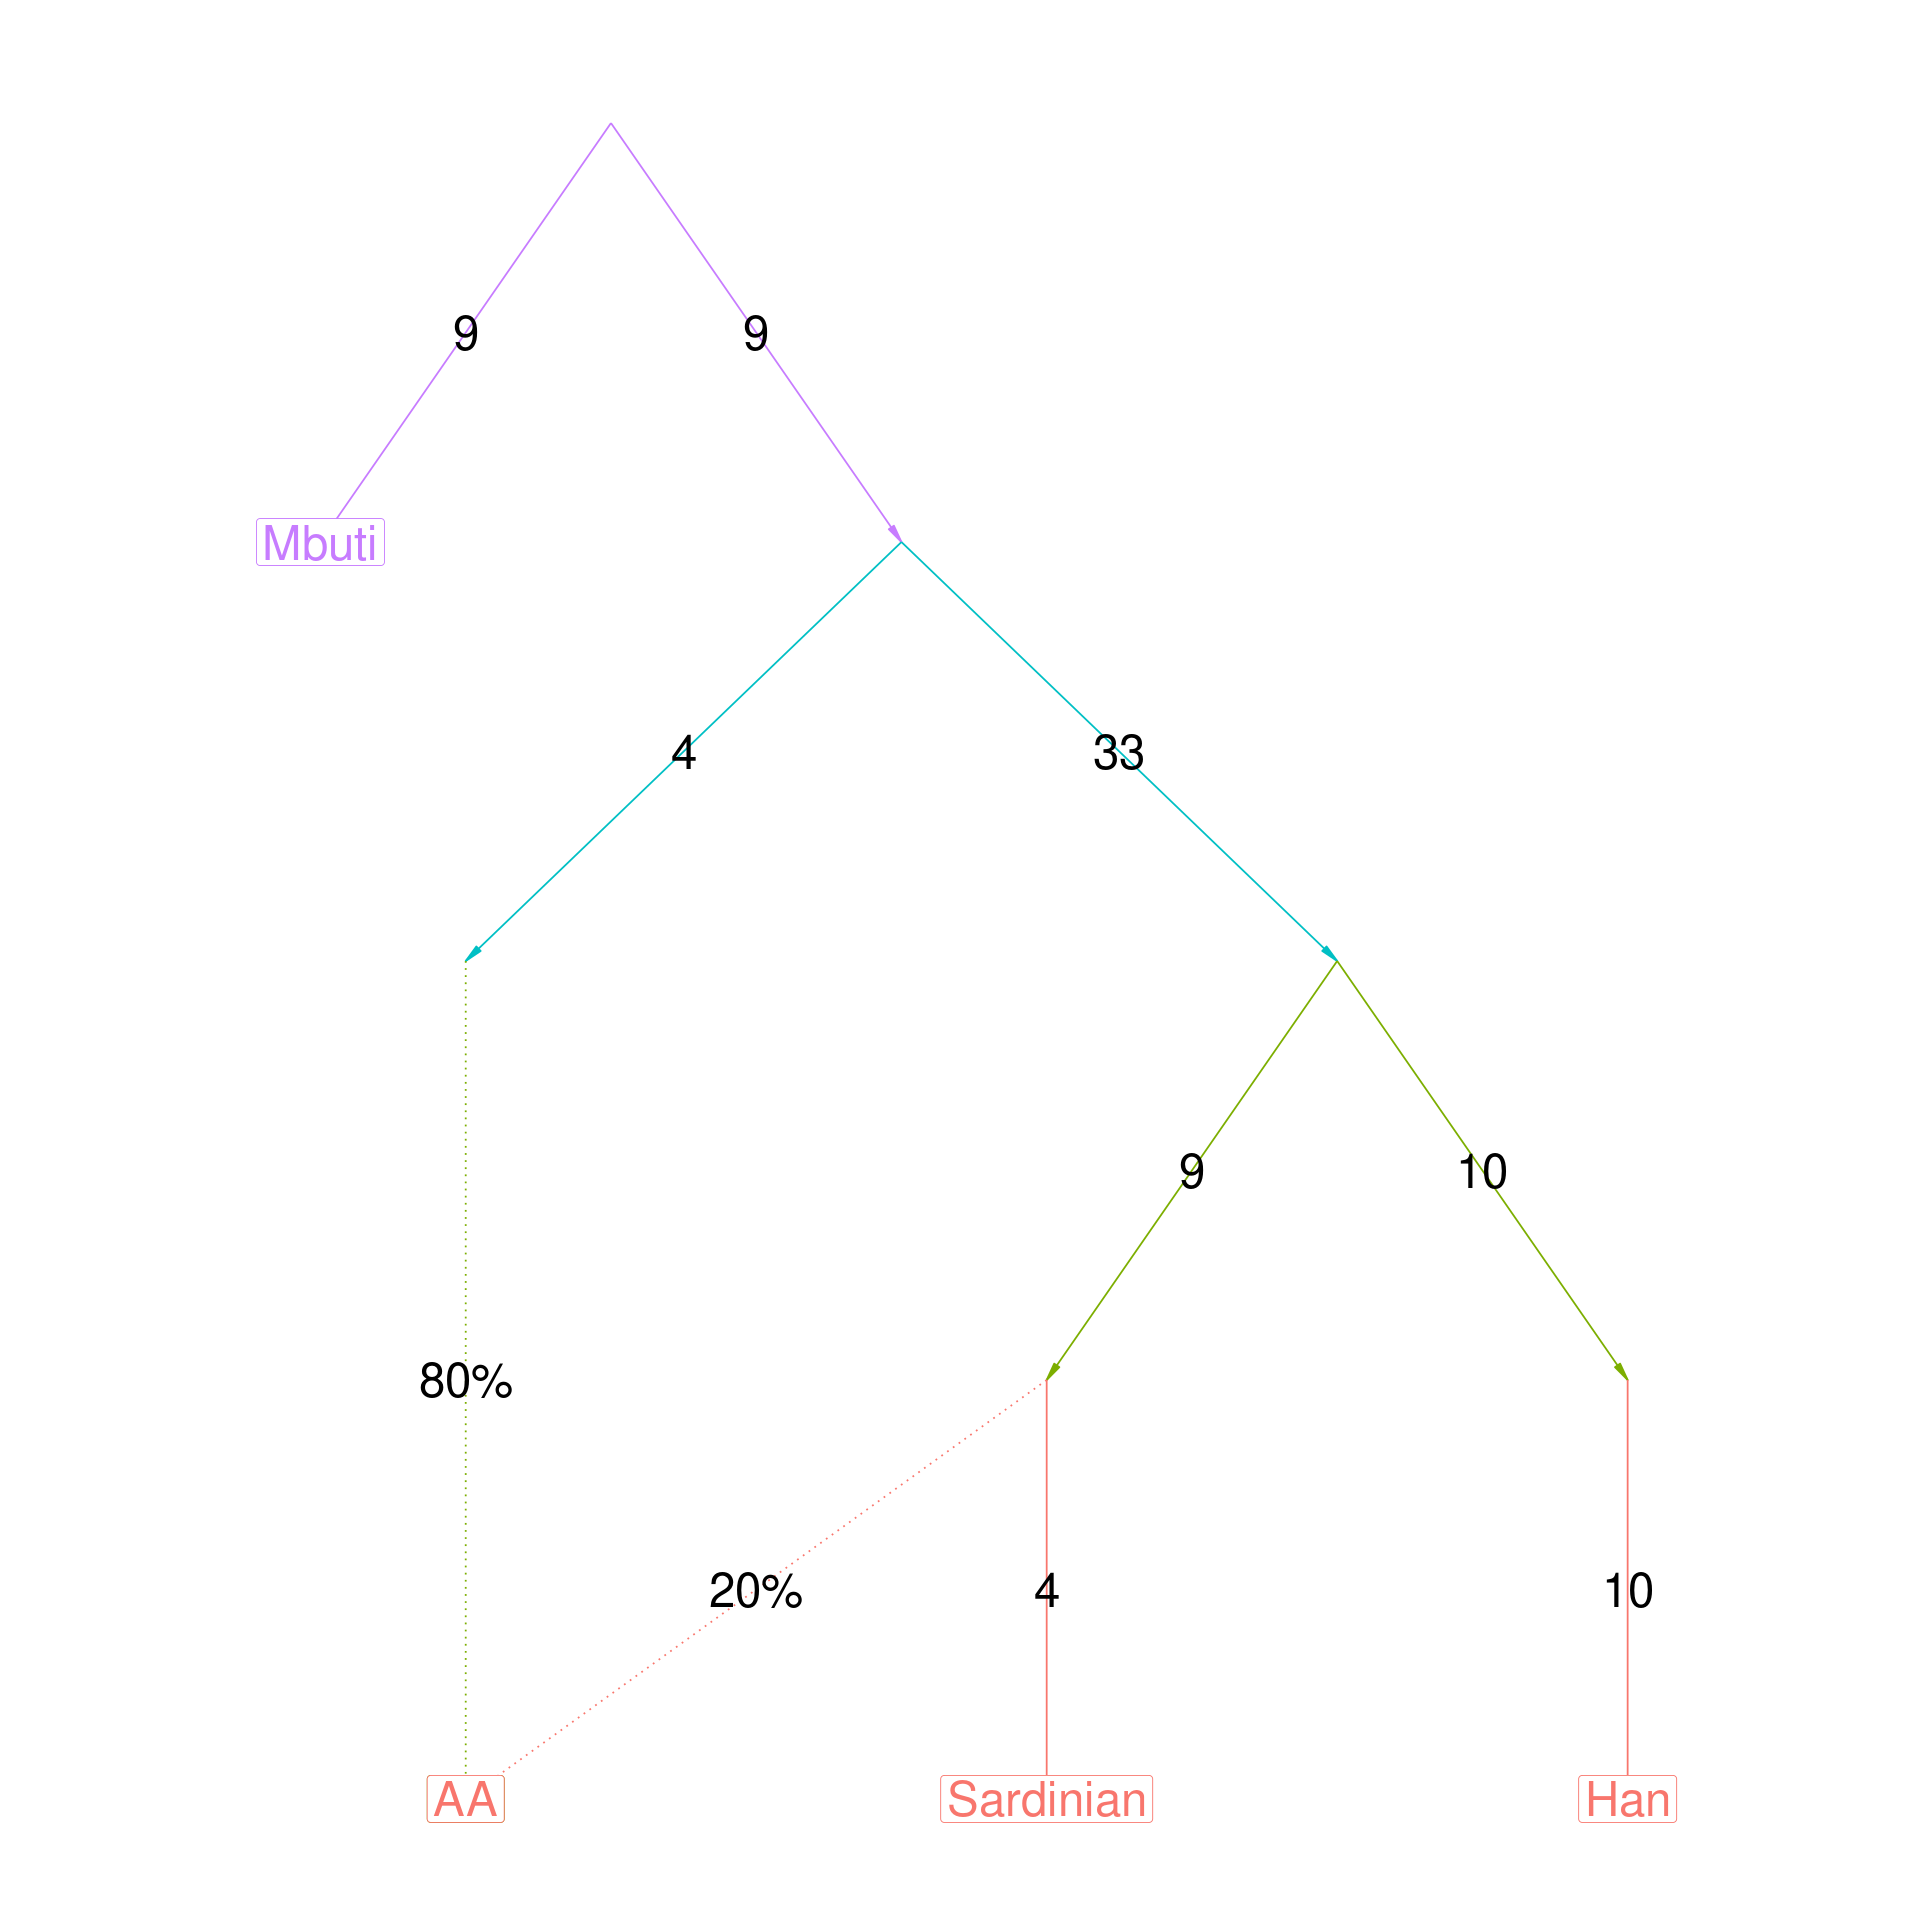

In [6]:
#fitting the graph is done using the qpgraph function:
G = qpgraph(f2s,starting_graph, return_fstats = T); 
plot_graph(G$edges, textsize=10)

Next, we can look at the fitted $f_2$-statistics

In [7]:
G$f2

pop1,pop2,est,se,fit,diff,z,p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mbuti,AA,0.02298698,0.0002453600,0.02298578,1.193700e-06,0.004865096,0.9961182
Mbuti,Sardinian,0.06382167,0.0004345402,0.06381450,7.172721e-06,0.016506463,0.9868303
Mbuti,Han,0.07039192,0.0004803555,0.07038467,7.253165e-06,0.015099578,0.9879527
AA,Sardinian,0.03346784,0.0003150060,0.03346382,4.022775e-06,0.012770471,0.9898109
AA,Han,0.04344543,0.0003414332,0.04344026,5.170395e-06,0.015143214,0.9879179
Sardinian,Han,0.03200879,0.0003060188,0.03200954,-7.502749e-07,-0.002451728,0.9980438


the columns
- `est` is the estimated f-statistic
- `se` is the estimated standard error
- `fit` is the f-statistic calculated under the model
- `diff` and `z` give the difference `fit-est` and associated Z-score, respectively.

If there are no Z-scores above 3 (or below -3), the model is often considered a fit to the data (again, with no claim about whether it is the best model). In this simple example, we only have 6 $f_2$-values and estimate 6 parameters (5 branch lengths and one admixture coefficient), so it is not surprising that we obtain a perfect fit.

**Task 2:** Assume we want to compare this model where the `AA`-population only has African Ancestry. For this purpose, remove the edge from `EUR` to `AA` from the graph. Does this model also fit?


**Task 3:** We picked `Sardinian` as a "proxy" for Europeans, and `Mbuti` as a proxy for Africans. What happens if we substitute them for other populations from the same region (e.g. `Sardinian -> Basque`, `Mbuti -> Yoruba`). What happens if we all add `Yoruba`, `Mbuti`, `Sardinian` and `Basque` to the model? 

## 4. Estimating Admixture Graphs using Treemix
`qpgraph` has the drawback that the user needs to specify the graph. This has the advantage that we retain fine-scale control over the fitting, but in many cases we would like to have a way to estimate the tree from data. 

This is the problem addressed by `treemix` [(Pickrell & Pritchard 2012)](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1002967). Unfortunately, the program has not been maintained for the last five+ years, so it is a little bit tedious to use. For this exercise, I converted the input files for the `world`-data set to treemix format (in `treemix/worldfoci2.treemix.in.gz`), and ran treemix with 0 to 5 admixture edges ((`-m 0` to `-m 5`), the resulting output are stored in the `treemix`-folder as well

In [8]:
#system("treemix -i treemix/worldfoci2.treemix.in.gz -m 0 -k 1000 -root Mbuti -o treemix/worldfoci2.treemix.m0")
#system("treemix -i treemix/worldfoci2.treemix.in.gz -m 1 -k 1000 -root Mbuti -o treemix/worldfoci2.treemix.m1")
#system("treemix -i treemix/worldfoci2.treemix.in.gz -m 2 -k 1000 -root Mbuti -o treemix/worldfoci2.treemix.m2")
#system("treemix -i treemix/worldfoci2.treemix.in.gz -m 3 -k 1000 -root Mbuti -o treemix/worldfoci2.treemix.m3")
#system("treemix -i treemix/worldfoci2.treemix.in.gz -m 4 -k 1000 -root Mbuti -o treemix/worldfoci2.treemix.m4")
#system("treemix -i treemix/worldfoci2.treemix.in.gz -m 5 -k 1000 -root Mbuti -o treemix/worldfoci2.treemix.m5")

The output of `treemix` will be two plots; one is the fitted graph, and one is a plot of the residuals that gives us some information about which pairs of populations are not fit well. We can use the `plot_treemix` and `plot_resid`-functions for this purpose:

Warning message in plot_treemix("/home/peter/fstats_tutorial/treemix/worldfoci2.treemix.m0"):
“NAs introduced by coercion”
Warning message in plot_treemix("/home/peter/fstats_tutorial/treemix/worldfoci2.treemix.m0"):
“NAs introduced by coercion”
Warning message in plot_treemix("/home/peter/fstats_tutorial/treemix/worldfoci2.treemix.m0"):
“NAs introduced by coercion”
Warning message in plot_treemix("/home/peter/fstats_tutorial/treemix/worldfoci2.treemix.m0"):
“NAs introduced by coercion”
Warning message in max(e[e[, 5] == "MIG", 4]):
“no non-missing arguments to max; returning -Inf”


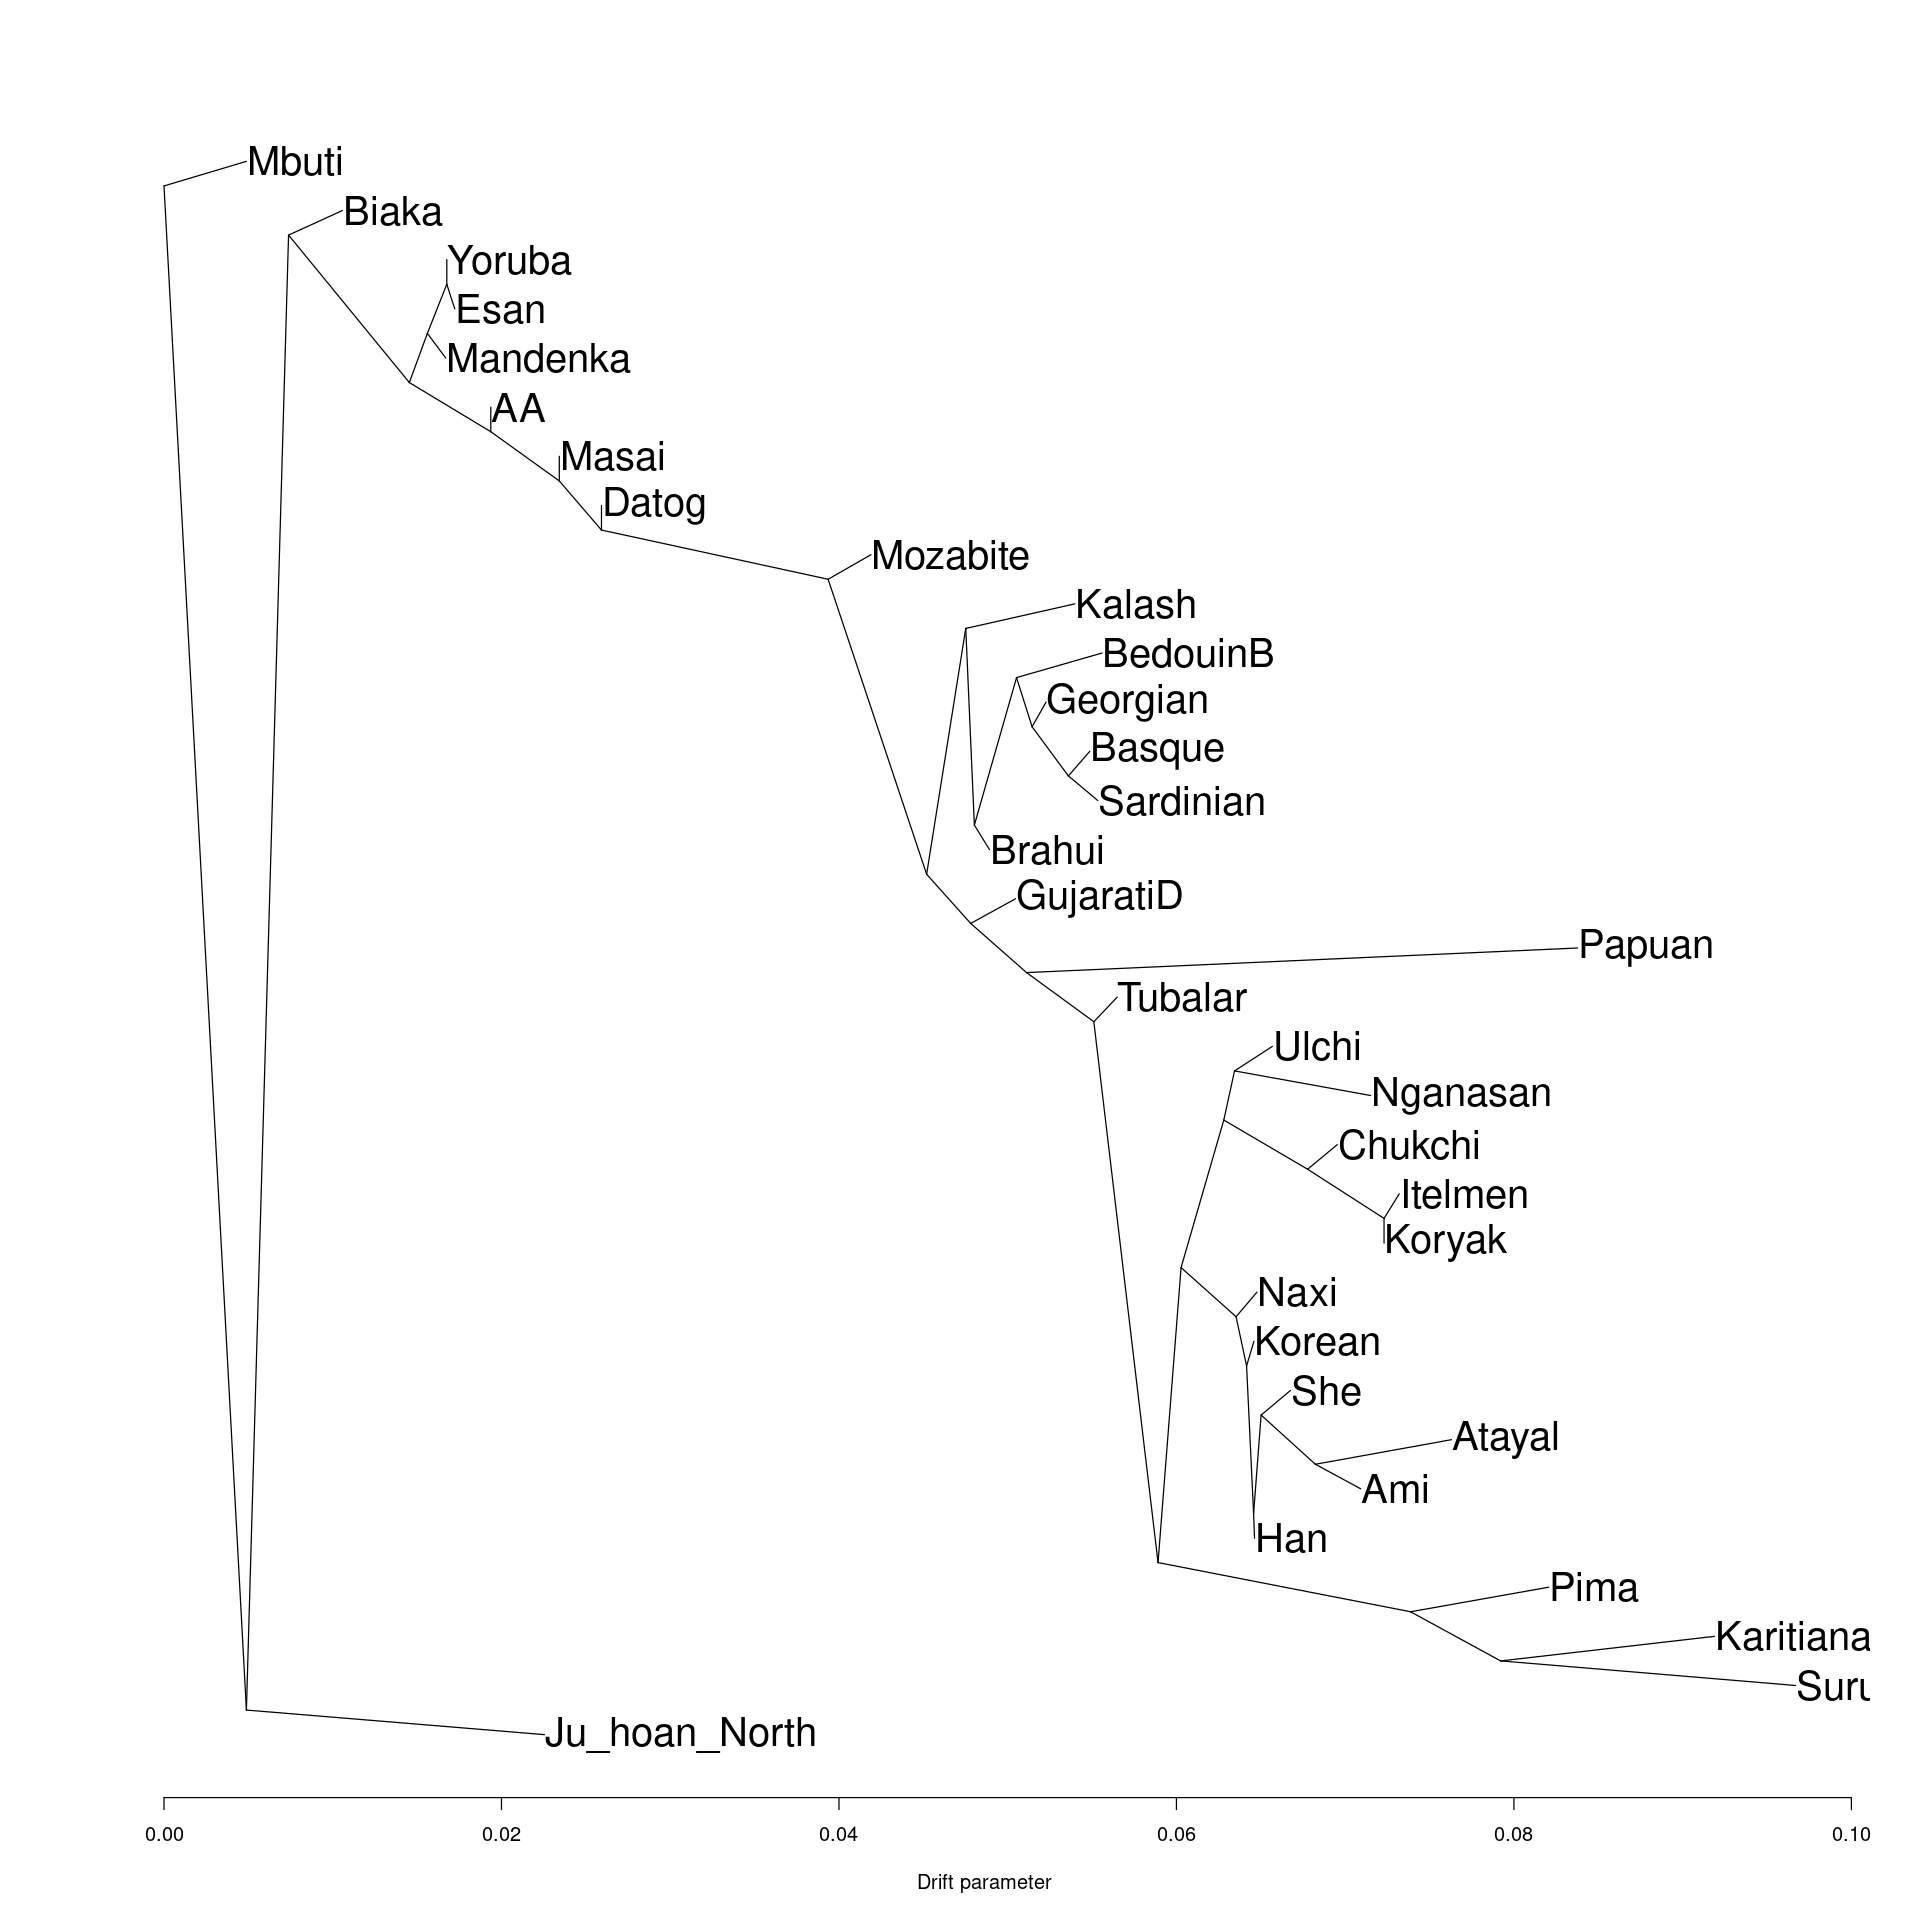

In [9]:
tm = plot_treemix('/home/peter/fstats_tutorial/treemix/worldfoci2.treemix.m0')

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“NAs introduced by coercion”


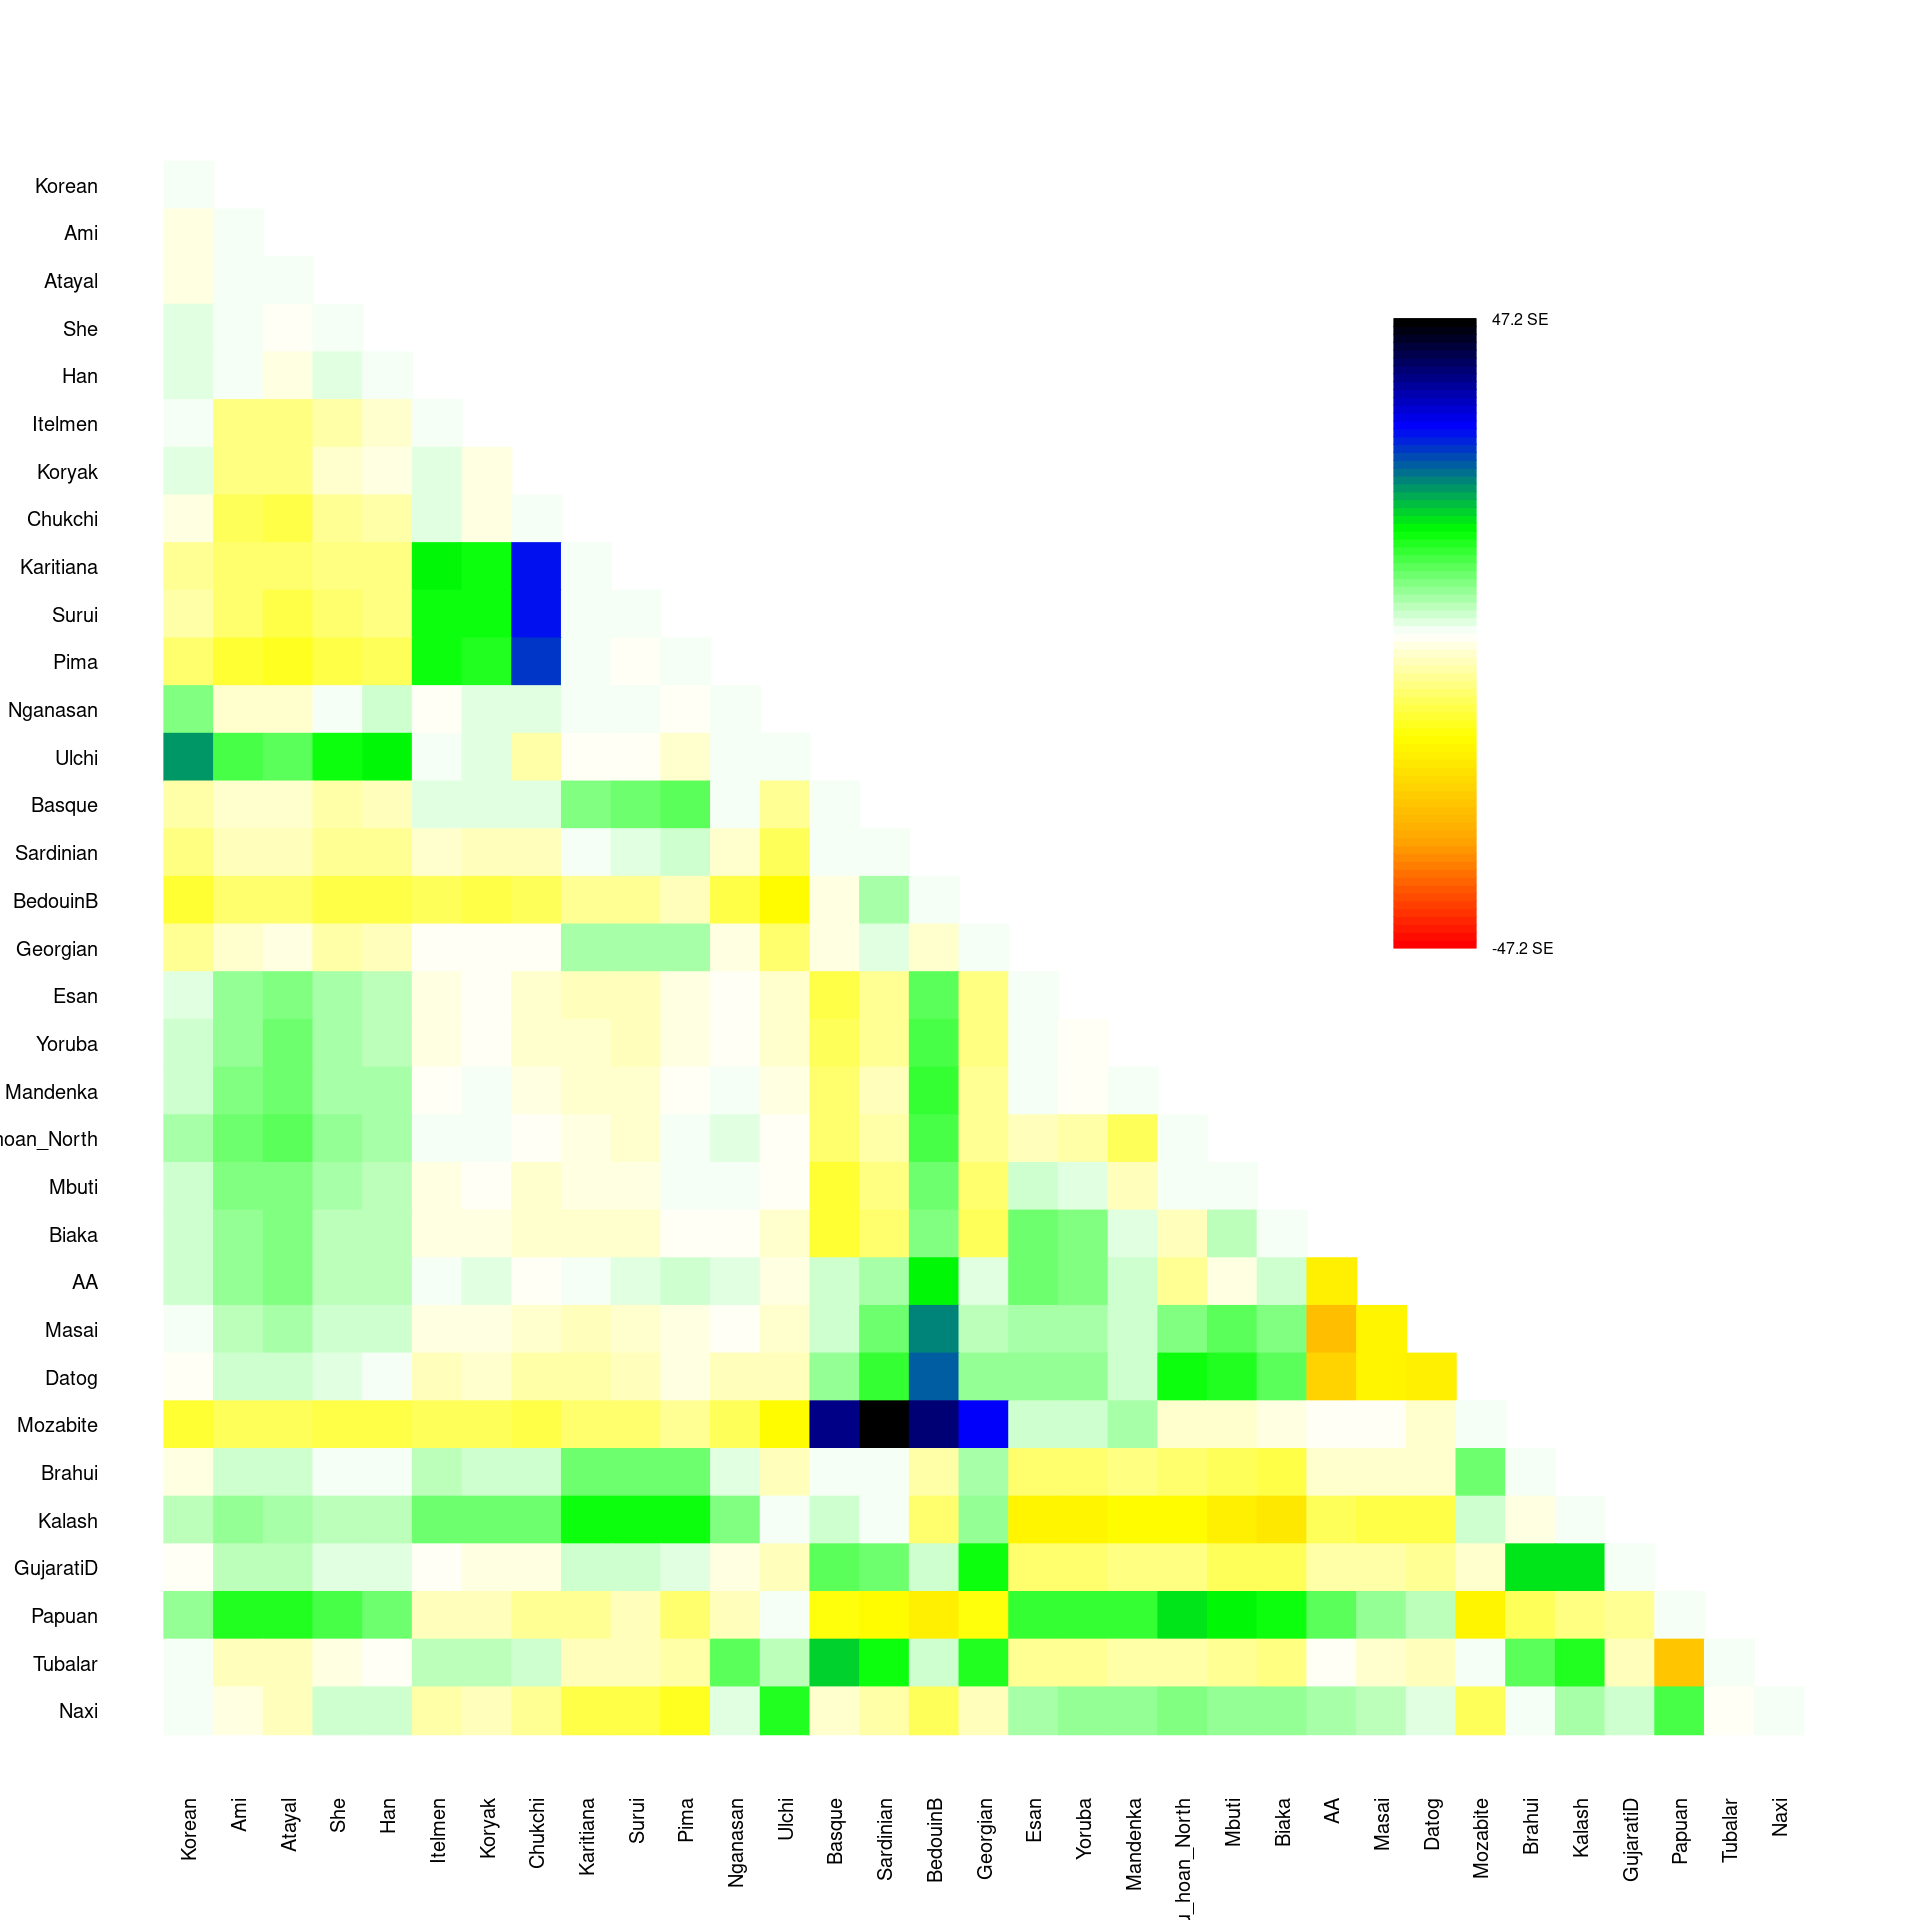

In [10]:
tree = nj(f2_mat)
res = plot_resid('/home/peter/fstats_tutorial/treemix/worldfoci2.treemix.m0', pop_order=get_tip_order(tree))

**Task 4**: Have a look at the admixture graphs and residual plots for `m=0` to `m=5`. 

- Does the fit improve when adding more admixture events?
- Can you predict how the fit improves?
- Does `m=5` provide a good fit?